# Converting `Ensembles`

This notebook takes you through the process of converting `Ensembles` from one parameterization to another in detail, and covers some of the things to watch out for when converting. 

In [7]:
import qp
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt 

First let's read in an `Ensemble` of Gaussian mixed model distributions. 

In [21]:
ens = qp.read("../assets/test.hdf5")
ens

Ensemble(the_class=mixmod,shape=(100, 3))

Now that we have our `Ensemble`, let's take a look at a few of the distributions.

Text(0, 0.5, 'P(x)')

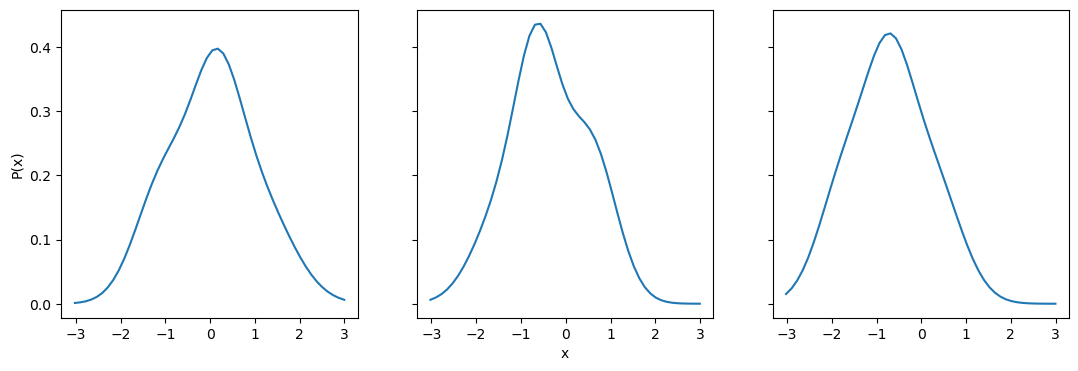

In [50]:
fig, axes = plt.subplots(1,3, sharex=True, sharey = True, figsize=(13,4))

axes[0].plot(ens.x_samples(),ens[2].pdf(ens.x_samples()))
axes[1].plot(ens.x_samples(),ens[15].pdf(ens.x_samples()))
axes[2].plot(ens.x_samples(),ens[53].pdf(ens.x_samples())) 
axes[1].set_xlabel("x")
axes[0].set_ylabel("P(x)")

## Converting to histograms and back

Now let's convert the `Ensemble` to histograms. We need to pick a set of bin edges that covers the whole range of values. Since `x_samples()` goes from (-3,3), we know that this range should cover the majority of distribution area for all of the distributions. However, for Gaussian mixed models it is possible for some of the distribution to be outside this range, particularly if it's the tail end. So let's add a bit on either side and do (-4,4) to make sure we cover the appropriate range. 

In [ ]:
bins = np.linspace(-4,4,41)
ens_h = qp.convert(ens, "hist", bins=bins)

Text(0.5, 0.98, 'Converting from Gaussian mixed models to histograms')

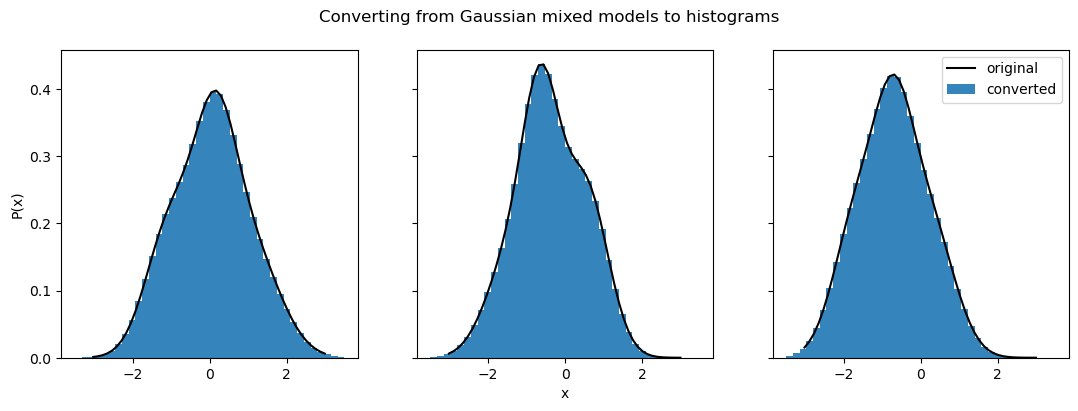

In [82]:
fig, axes = plt.subplots(1,3, sharex=True, sharey = True, figsize=(13,4))


# we use a bar to plot the histogram since we already have the histogram values
axes[0].bar(ens_h.x_samples(),ens_h[2].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9) 
axes[0].plot(ens.x_samples(),ens[2].pdf(ens.x_samples()),c="k")
axes[1].bar(ens_h.x_samples(),ens_h[15].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9)
axes[1].plot(ens.x_samples(),ens[15].pdf(ens.x_samples()),c="k")
axes[2].bar(ens_h.x_samples(),ens_h[53].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9, label="converted")
axes[2].plot(ens.x_samples(),ens[53].pdf(ens.x_samples()),c="k", label="original") 
axes[1].set_xlabel("x")
axes[0].set_ylabel("P(x)")
axes[2].legend(loc="best")
fig.suptitle("Converting from Gaussian mixed models to histograms")

The conversion seems to have worked quite well. The distributions we looked at before match up almost perfectly. Now let's try converting these back to Gaussian mixed models to see if the conversion in the other direction works as well.

In [55]:
ens_conv = qp.convert(ens_h,"mixmod",ncomps=3)

Text(0.5, 0.98, 'Converting histograms to Gaussian mixed models')

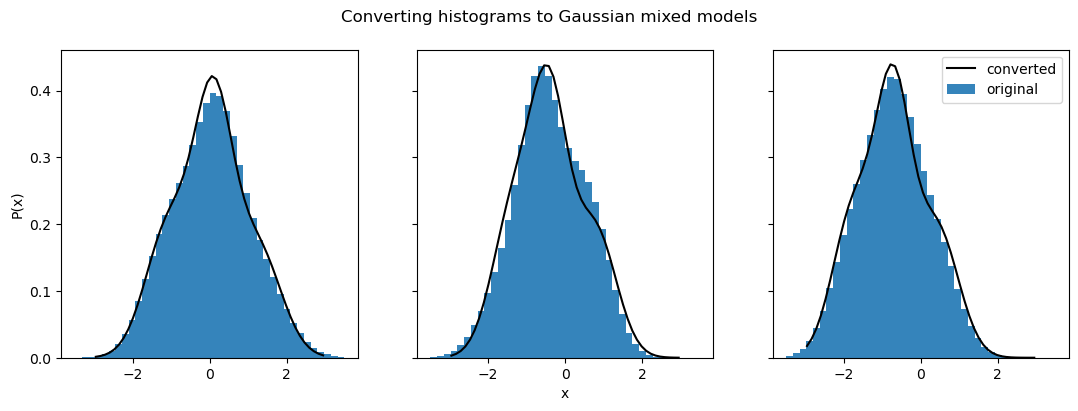

In [86]:
fig, axes = plt.subplots(1,3, sharex=True, sharey = True, figsize=(13,4))


# we use a bar to plot the histogram since we already have the histogram values
axes[0].bar(ens_h.x_samples(),ens_h[2].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9) 
axes[0].plot(ens_conv.x_samples(),ens_conv[2].pdf(ens_conv.x_samples()),c="k")
axes[1].bar(ens_h.x_samples(),ens_h[15].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9)
axes[1].plot(ens_conv.x_samples(),ens_conv[15].pdf(ens_conv.x_samples()),c="k")
axes[2].bar(ens_h.x_samples(),ens_h[53].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9, label="original")
axes[2].plot(ens_conv.x_samples(),ens_conv[53].pdf(ens_conv.x_samples()),c="k", label="converted") 
axes[1].set_xlabel("x")
axes[0].set_ylabel("P(x)")
axes[2].legend(loc="best")
fig.suptitle("Converting histograms to Gaussian mixed models")

Our converted Gaussian mixed model distributions no longer match the histograms they were converted from as well. We can also compare them back to their original distributions to get a better sense of the differences:

Text(0.5, 0.98, 'Comparison between converted distributions and originals')

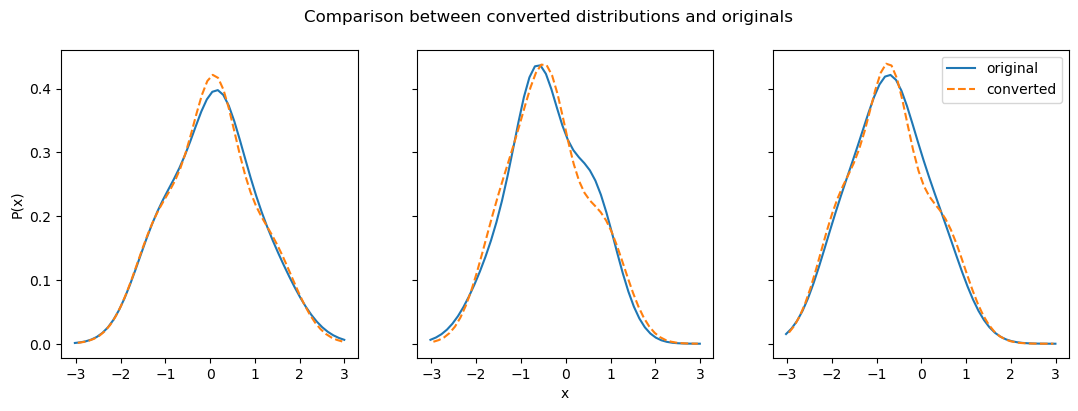

In [80]:
fig, axes = plt.subplots(1,3, sharex=True, sharey = True, figsize=(13,4))

axes[0].plot(ens.x_samples(),ens[2].pdf(ens.x_samples()))
axes[0].plot(ens_conv.x_samples(),ens_conv[2].pdf(ens_conv.x_samples()),linestyle="--")
axes[1].plot(ens.x_samples(),ens[15].pdf(ens.x_samples()))
axes[1].plot(ens_conv.x_samples(),ens_conv[15].pdf(ens_conv.x_samples()),linestyle="--")
axes[2].plot(ens.x_samples(),ens[53].pdf(ens.x_samples()), label="original") 
axes[2].plot(ens_conv.x_samples(),ens_conv[53].pdf(ens_conv.x_samples()),linestyle="--",label="converted") 
axes[1].set_xlabel("x")
axes[0].set_ylabel("P(x)")
axes[2].legend(loc="best")
fig.suptitle("Comparison between converted distributions and originals")

One factor here is that conversion to Gaussian mixture models requires an input number of Gaussian models per distribution (by default = 3). If not all of the distributions in your `Ensemble` contain the same number of Gaussian models (can be done by setting values to 0), then you can get overfitting of those that are best fit by fewer Gaussian models, as you can see happening in the plot on the right. 

Beyond this, even those distributions that clearly require more than one Gaussian have fits that depart from the original in some way. This is because the method used to convert to Gaussian mixture models takes samples from the input `Ensemble` distributions and then fits the sampled data. This method is inherently inconsistent, due to the random nature of sampling and the dependence on fitting algorithms. This means that converting to a Gaussian mixture model from the same `Ensemble` multiple times can give you different results each time.

Let's explore some other conversion methods to see how they perform.

## Converting to interpolations

Interpolations are quite similar to histograms in terms of data structure. Converting to an interpolation requires a set of x values, and those x values need to cover the full range of all the distributions in the `Ensemble`. Let's use the same range and number of values as the histogram to convert to an interpolation, and take a look at our distributions.

In [62]:
ens_i = qp.convert(ens_h,"interp",xvals=np.linspace(-4,4,40))

Text(0.5, 0.98, 'Converting histograms to interpolation')

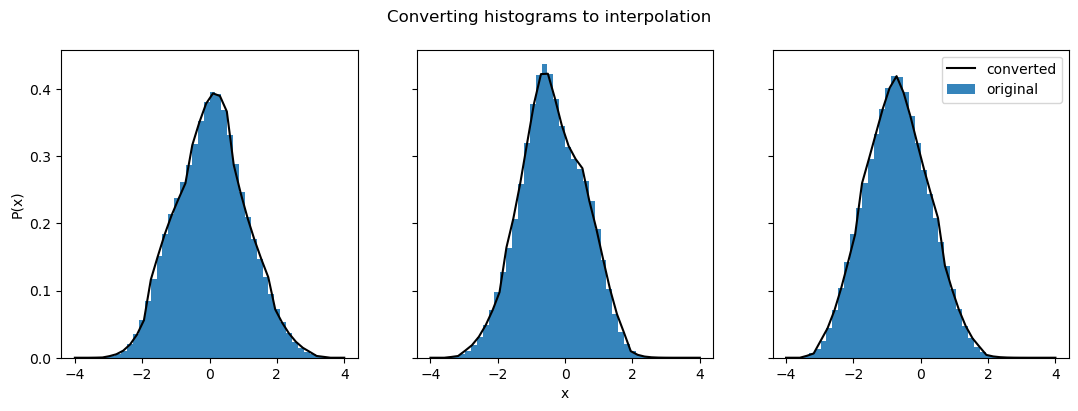

In [85]:
fig, axes = plt.subplots(1,3, sharex=True, sharey = True, figsize=(13,4))


# we use a bar to plot the histogram since we already have the histogram values
axes[0].bar(ens_h.x_samples(),ens_h[2].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9) 
axes[0].plot(ens_i.x_samples(),ens_i[2].pdf(ens_i.x_samples()),c="k")
axes[1].bar(ens_h.x_samples(),ens_h[15].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9)
axes[1].plot(ens_i.x_samples(),ens_i[15].pdf(ens_i.x_samples()),c="k")
axes[2].bar(ens_h.x_samples(),ens_h[53].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9, label="original")
axes[2].plot(ens_i.x_samples(),ens_i[53].pdf(ens_i.x_samples()),c="k", label="converted") 
axes[1].set_xlabel("x")
axes[0].set_ylabel("P(x)")
axes[2].legend(loc="best")
fig.suptitle("Converting histograms to interpolation")

Not surprisingly, this conversion gives us a good match between the distributions. 

In [92]:
ens_i_lowres = qp.convert(ens_h, "interp",xvals=np.linspace(-4,4,10))

Text(0.5, 0.98, 'Converting to interpolation with fewer bins')

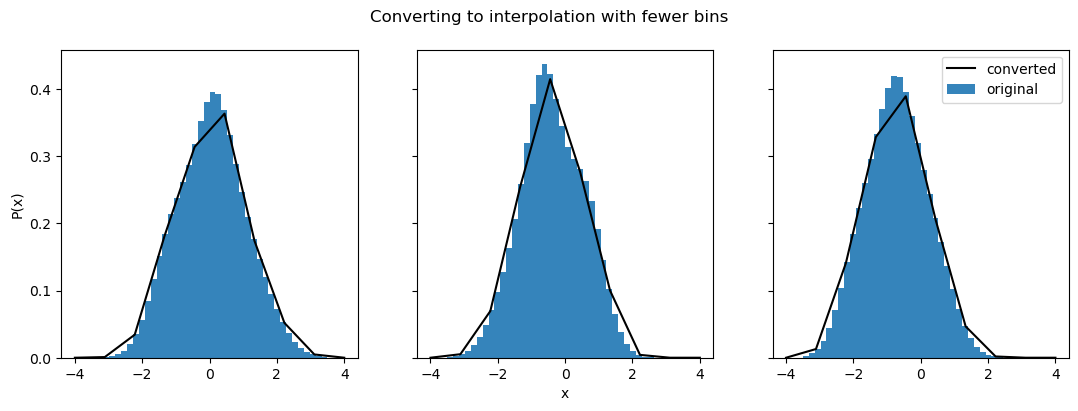

In [93]:
fig, axes = plt.subplots(1,3, sharex=True, sharey = True, figsize=(13,4))


# we use a bar to plot the histogram since we already have the histogram values
axes[0].bar(ens_h.x_samples(),ens_h[2].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9) 
axes[0].plot(ens_i_lowres.x_samples(),ens_i_lowres[2].pdf(ens_i_lowres.x_samples()),c="k")
axes[1].bar(ens_h.x_samples(),ens_h[15].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9)
axes[1].plot(ens_i_lowres.x_samples(),ens_i_lowres[15].pdf(ens_i_lowres.x_samples()),c="k")
axes[2].bar(ens_h.x_samples(),ens_h[53].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9, label="original")
axes[2].plot(ens_i_lowres.x_samples(),ens_i_lowres[53].pdf(ens_i_lowres.x_samples()),c="k", label="converted") 
axes[1].set_xlabel("x")
axes[0].set_ylabel("P(x)")
axes[2].legend(loc="best")
fig.suptitle("Converting to interpolation with fewer bins")

Converting from histogram to interpolation is a bit more consistent. 

In [68]:
ens_q = qp.convert(ens_h, "quant", quants=np.linspace(0.01,0.99,20))

Text(0.5, 0.98, 'Converting histograms to quantiles')

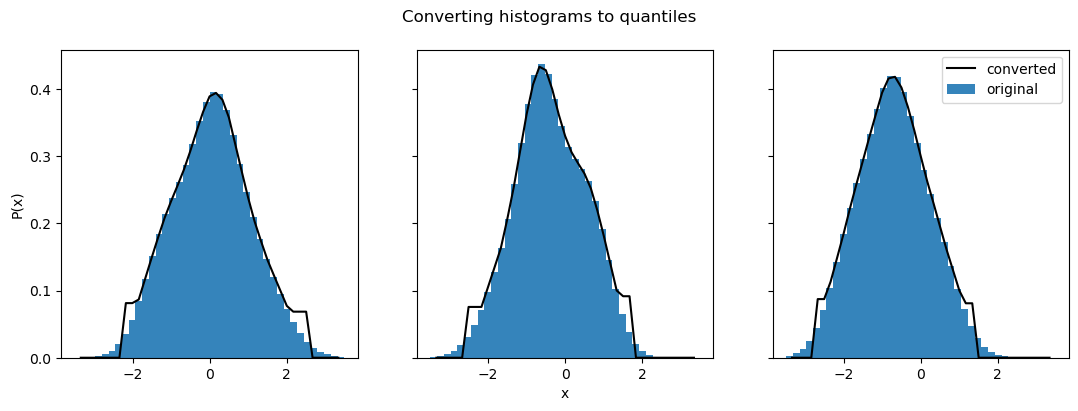

In [76]:
fig, axes = plt.subplots(1,3, sharex=True, sharey = True, figsize=(13,4))


# we use a bar to plot the histogram since we already have the histogram values
axes[0].bar(ens_h.x_samples(),ens_h[2].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9) 
axes[0].plot(ens_q.x_samples(),ens_q[2].pdf(ens_q.x_samples()),c="k")
axes[1].bar(ens_h.x_samples(),ens_h[15].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9)
axes[1].plot(ens_q.x_samples(),ens_q[15].pdf(ens_q.x_samples()),c="k")
axes[2].bar(ens_h.x_samples(),ens_h[53].pdf(ens_h.x_samples()), width=ens_h.x_samples()[1]-ens_h.x_samples()[0], alpha=0.9, label="original")
axes[2].plot(ens_q.x_samples(),ens_q[53].pdf(ens_q.x_samples()),c="k", label="converted") 
axes[1].set_xlabel("x")
axes[0].set_ylabel("P(x)")
axes[2].legend(loc="best")
fig.suptitle("Converting histograms to quantiles")

Converting to a quantile parameterization works very well for the main portion of a distribution, but can be a bit rough at the edges.